# 2 Recognising digits using a convolutional neural network

In the previous notebook, you saw how we could collect image data sampled by the robot within the simulator into the notebook environment and then test the collected images against an "offboard" pretrained multilayer perceptron run via the notebook's Python environment. However, even with an MLP tested on "jiggled" images, the network's classification performance degrades when "off-center" images are presented to it.

In this notebook, you will see how we can use a convolutional neural network running in the notebook's Python environment to classify images retrieved from the robot in the simulator.

## 2.1 Using a pre-trained convolutional neural network

Although training a convolutional neural network can take quite a lot of time, and a *lot* of computational effort, off-the-shelf pre-trained models are also increasingly available. However, whilst this means you may be able to get started on a recognition task without the requirement to build your own model, you would do well to remember the phrase *caveat emptor*: buyer beware.

When you use a pre-trained model, you may not know what data it was trained against (and what biases it may include because of that), and you may not know what weaknesses there may be in the model.

As with any area of IT, privacy and security concerns must always be taken into account. With the increasing number of neural networks being deployed, they are starting to become attractive to attackers, although we will not be considering such matters in this module (for an example of related concerns, see *Biggio, B. and Roli, F., 2018. Wild patterns: Ten years after the rise of adversarial machine learning. Pattern Recognition, 84, pp.317-331* [[PDF](https://arxiv.org/pdf/1712.03141.pdf)]).

However, you should be aware when using third party models that they may incorporate risks and threats when you come to use them. For example, __risks__ associated with *bias* in the training data used to train the network, or in its final trained performance; or __threats__ in terms of incorporating patterns that are deliberately misidentifed compared to how you might ordinarily expect them to be identified.

The following example uses a pretrained convolutional neural network model implemented as a TensorFlow Lite model. [*TensorFlow Lite*](https://www.tensorflow.org/lite/) is a framework developed to support the deployment of TensorFlow Model on internet of things (IoT) devices. As such, the models are optimised to be as small as possible and to be evaluated as computationally quickly and efficiently as possible.

### 2.1.1 Loading the CNN

The first thing we need to do is to load in the model. The actual TensorFlow Lite framework code is a little bit fiddly in places, so we'll use some convenience functions to make using the framework slightly easier.

The first thing we need to do is to load in the CNN model:

In [1]:
from nn_tools.network_views import cnn_load

cnn = cnn_load(fpath='./mnist.tflite',
               fpath_labels='./mnist_tflite_labels.txt')

We can then preview the architecture of the network:

In [2]:
from nn_tools.network_views import cnn_get_details
cnn_get_details(cnn, report=True)



Input: [{'name': 'conv2d_4_input', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]

Output: [{'name': 'Identity', 'index': 23, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]



The main take away from this report are the items the describe the structure of the input and output arrays. In particular, we have an input array of a single 28x28 pixel greyscale image array, and an output of 10 classification classes. Each output gives the probability with which the CNN believes the image represents the corresponding digit.

### 2.1.2 Testing the network

We'll test the network with images retrieved from the simulator.

First, load in the simulator in the normal way:

In [1]:
from nbev3devsim.load_nbev3devwidget import roboSim, eds

%load_ext nbev3devsim

<IPython.core.display.Javascript object>

Ev3DevWidget(status='deferring flush until render')

Load the *MNIST_Digits* background and sample an image:

In [2]:
%%sim_magic_preloaded -b MNIST_Digits_Black -OA -R -x 400 -y 850

# Configure a light sensor
colorLeft = ColorSensor(INPUT_2)

#Sample the light sensor reading
sensor_value = colorLeft.reflected_light_intensity

# This is a command invocation rather than a print statement
print("image_data left")
# The command is responded to by
# the "Image data logged..." message display

We can retrieve the data from the simulator into the notebook Python environment:

In [36]:
roboSim.image_data()

,side,vals,clock
0,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
1,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
2,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
3,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
4,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1
5,left,"245,226,225,245,226,225,245,226,225,245,226,22...",1


Preview the last image collected, cropping it to the central focal area:

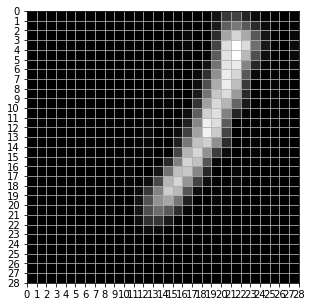

In [38]:
from nn_tools.sensor_data import generate_image, zoom_img
index = -1 # Get the last image in the dataframe

img = generate_image(roboSim.image_data(),
                     index,
                     crop=(3, 3, 17, 17),
                     resize=(28, 28))
zoom_img(img)

We can now present this image to the CNN and see what digit it thinks the image corresponds to:

0.999991: 1
0.000009: 4


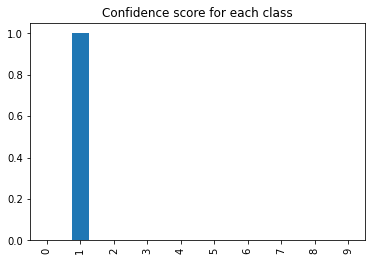

In [30]:
from nn_tools.network_views import cnn_test_with_image

# Pass rank=N to print top N ranked results
cnn_test_with_image(cnn, img, rank=2)

Let's perturb that image slightly by randomly jiggling it: 

(None, None)

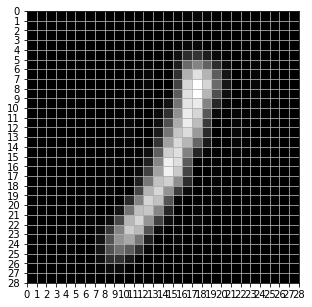

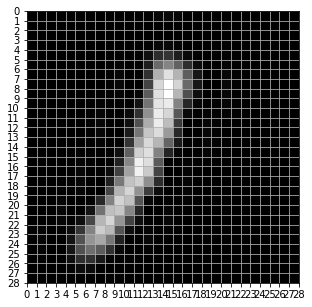

In [31]:
from nn_tools.sensor_data import jiggle

jiggled_img = jiggle(img)

zoom_img(img), zoom_img(jiggled_img)

Now we can test how well the network copes with classifying it when it has been randomly translated:

0.999998: 1
0.000002: 4


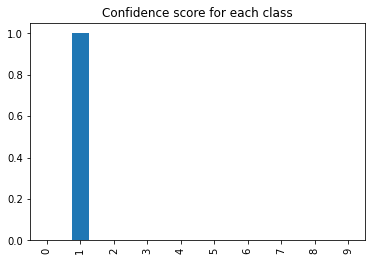

In [32]:
cnn_test_with_image(cnn, jiggled_img, rank=2)

How well does the network perform if we offset the image retrieved from the simulator?

Use some magic to relocate the robot slightly off-center from one of the images:

In [33]:
%sim_magic -OAR -x 398 -y 848

Now grab the sensor data and generate an image from it. Can you see how the image is now offset from the central location, as some of the jiggled images were?

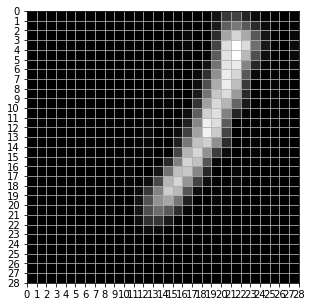

In [34]:
img = generate_image(roboSim.image_data(),
                     index,
                     crop=(3, 3, 17, 17),
                     resize=(28, 28))
zoom_img(img)

Let's test this offset image to see if our convolutional neural network can still correctly identify the digit:

0.999580: 1
0.000408: 4


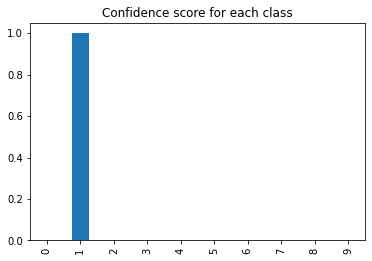

In [35]:
cnn_test_with_image(cnn, img, rank=2)

### 2.1.3 Activity — Testing the CNN using robot collected image samples

The `ipywidget` powered end user application defined in the code cell below will place the robot at a randomly selected digit location and display and then test the image grabbed from *the previous location* using the CNN.

Run the application several times. How successful is the CNN at classifying the image?

Tick the *location_noise* box to add a small amount of perturbation to where the robot is placed. How well does the CNN perform?

Can the CNN still recognised the image in the presence of sensor noise?

*Record your observations here.*

In [50]:
from ipywidgets import interact_manual
import random
from time import sleep

@interact_manual(location_noise=True)
def random_MNIST_location(location_noise = False):
    """Place the robot at a random MNIST digit location."""
    _x = random.randint(0, 19)*100+100
    _y = random.randint(0, 10)*100+50
    
    if location_noise:
        _x += random.randint(-3, 3)
        _y += random.randint(-3, 3)

    %sim_magic -OAR -x $_x -y $_y
    img = generate_image(roboSim.image_data(),
                     -1,
                     crop=(3, 3, 17, 17),
                     resize=(28, 28))
    zoom_img(img)
    cnn_test_with_image(cnn, img, rank=3)

interactive(children=(Checkbox(value=True, description='location_noise'), Button(description='Run Interact', s…

## 2.2 Summary

In this notebook, you have seen how we can use a convolutional neural network to identify handwritten digits scanned by the robot in the simulator.

In the next notebook, you will see how we can collect data from a new dataset, along with training labels, and then use that data to train a new neural network.